## Carga de datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv('kdd_completo.csv')
print("Primeras filas del dataset original:")
df.head()


Primeras filas del dataset original:


,Alumno,HorasEstudio,ParticipacionForo,UsoCampusVirtual,SatisfaccionGeneral,Claridad,Profesorado,Edad,NotaFinal,Fecha
0,A1,2,1.0,5,3,2,3,17,6.5,2025-04-01
1,A2,5,5.0,4,5,5,5,18,8.2,2025-04-01
2,A3,3,2.0,3,4,4,4,17,7.1,2025-04-01
3,A4,4,4.0,5,4,4,4,18,7.5,2025-04-01
4,A5,NaN,1.0,2,2,2,2,16,5.2,2025-04-01


## 1. PREPROCESAMIENTO

In [4]:
# Reemplazo de errores tipográficos
df['HorasEstudio'] = df['HorasEstudio'].replace("tres", 3)

# Columnas a convertir a numérico
cols_to_numeric = ['HorasEstudio', 'ParticipacionForo', 'UsoCampusVirtual', 
                   'SatisfaccionGeneral', 'Claridad', 'Profesorado', 
                   'Edad', 'NotaFinal']

# Conversión forzada con manejo de errores
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Imputar valores nulos con la media en lugar de eliminar columnas
df[cols_to_numeric] = df[cols_to_numeric].fillna(df[cols_to_numeric].mean())

print("Nulos restantes por columna:")
print(df.isnull().sum())


Nulos restantes por columna:
Alumno                 0
HorasEstudio           0
ParticipacionForo      0
UsoCampusVirtual       0
SatisfaccionGeneral    0
Claridad               0
Profesorado            0
Edad                   0
NotaFinal              0
Fecha                  0
dtype: int64


Normalización y variables derivadas

In [6]:

scaler = MinMaxScaler()
num_cols = ['ParticipacionForo', 'Claridad', 'UsoCampusVirtual', 'HorasEstudio']
df[num_cols] = scaler.fit_transform(df[num_cols])

# Nueva variable: Compromiso
df['Compromiso'] = df[['ParticipacionForo', 'HorasEstudio']].mean(axis=1)

df.head()


,Alumno,HorasEstudio,ParticipacionForo,UsoCampusVirtual,SatisfaccionGeneral,Claridad,Profesorado,Edad,NotaFinal,Fecha,Compromiso
0,A1,0.000000,0.00,1.00,3,0.000000,3,17,6.5,2025-04-01,0.000000
1,A2,0.750000,1.00,0.75,5,1.000000,5,18,8.2,2025-04-01,0.875000
2,A3,0.250000,0.25,0.50,4,0.666667,4,17,7.1,2025-04-01,0.250000
3,A4,0.500000,0.75,1.00,4,0.666667,4,18,7.5,2025-04-01,0.625000
4,A5,0.458333,0.00,0.25,2,0.000000,2,16,5.2,2025-04-01,0.229167


## 2. CLASIFICACIÓN

Distribución de clases en la variable objetivo:
SatisfaccionGeneral
4    7
5    6
3    4
2    3
Name: count, dtype: int64
              precision    recall  f1-score   support

           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1

    accuracy                           0.80         5
   macro avg       0.62      0.75      0.67         5
weighted avg       0.70      0.80      0.73         5



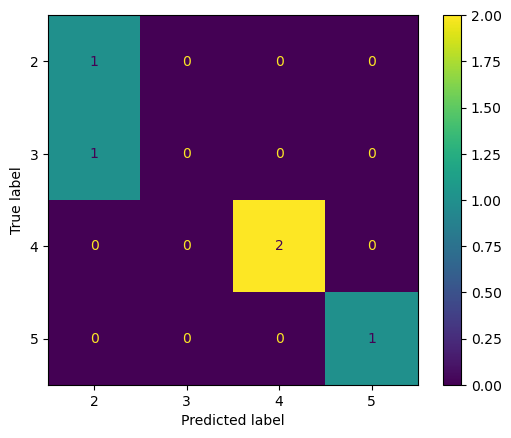

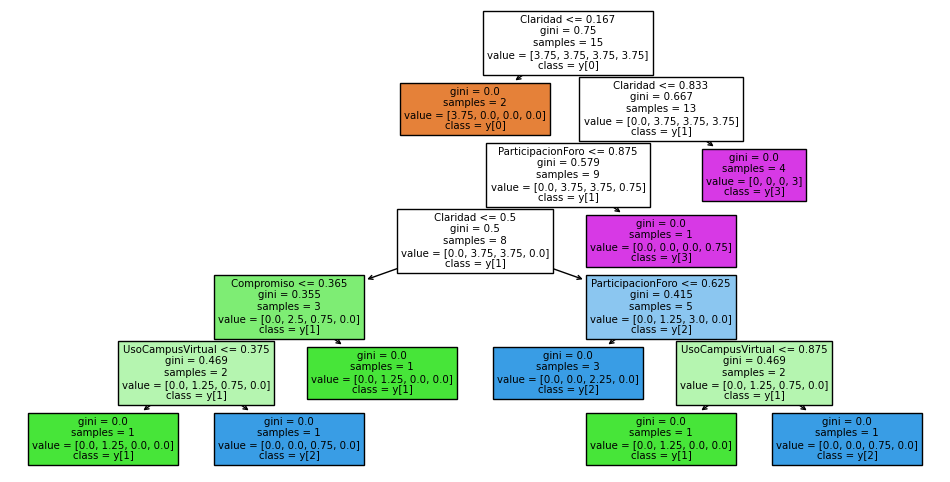

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Definir variables
X = df[['ParticipacionForo', 'Claridad', 'UsoCampusVirtual', 'HorasEstudio', 'Compromiso']]
y = df['SatisfaccionGeneral']

# Revisar balance de clases
print("Distribución de clases en la variable objetivo:")
print(y.value_counts())

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Entrenar modelo con balanceo de clases
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluación con zero_division=0 para evitar warnings
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# Visualizar árbol
plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=X.columns, class_names=True, filled=True)
plt.show()


## 3. REGRESIÓN

Coeficientes: [1.52674016 1.43260496 0.43005238]
Intercepto: 5.466796966617155
R^2: 0.46503952629309575
RMSE: 0.6525553900403364


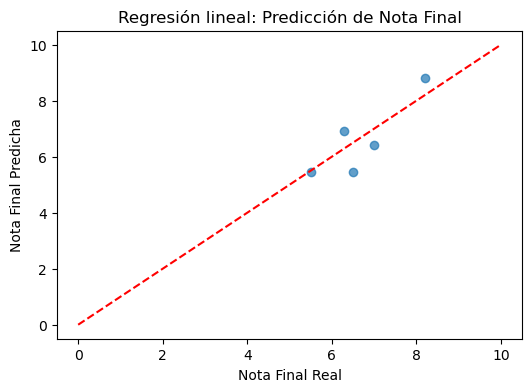

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_reg = df[['ParticipacionForo', 'Claridad', 'Compromiso']]
y_reg = df['NotaFinal']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, random_state=42)

lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)

y_pred_reg = lr.predict(X_test_reg)

print("Coeficientes:", lr.coef_)
print("Intercepto:", lr.intercept_)
print("R^2:", r2_score(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7)
plt.xlabel("Nota Final Real")
plt.ylabel("Nota Final Predicha")
plt.title("Regresión lineal: Predicción de Nota Final")
plt.plot([0, 10], [0, 10], 'r--')
plt.show()

## 4. CLUSTERING

Promedios por Cluster:
         ParticipacionForo  HorasEstudio  UsoCampusVirtual  Claridad
Cluster                                                             
0                 0.250000      0.316667          0.400000  0.333333
1                 0.833333      0.666667          0.805556  0.851852
2                 0.000000      0.000000          1.000000  0.000000


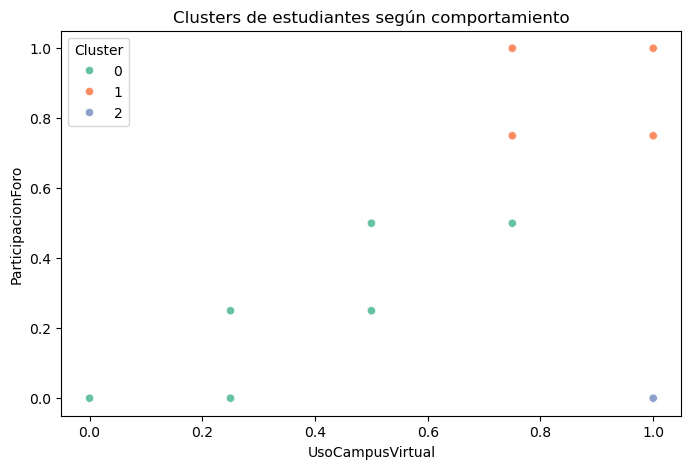

In [22]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

from sklearn.cluster import KMeans

# Variable para arreglar error de cpu
LOKY_MAX_CPU_COUNT = 1

os.environ["OMP_NUM_THREADS"] = "1"

X_cluster = df[['ParticipacionForo', 'HorasEstudio', 'UsoCampusVirtual', 'Claridad']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

print("Promedios por Cluster:")
print(df.groupby('Cluster')[['ParticipacionForo', 'HorasEstudio', 'UsoCampusVirtual', 'Claridad']].mean())

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='UsoCampusVirtual', y='ParticipacionForo', hue='Cluster', palette='Set2')
plt.title("Clusters de estudiantes según comportamiento")
plt.show()

## 5. ASOCIACIÓN

In [24]:
# Regla manual
df['Regla_Alta_Claridad_CV'] = np.where(
    (df['Claridad'] > 0.6) & (df['UsoCampusVirtual'] > 0.6),
    np.where(df['SatisfaccionGeneral'] >= 4, 'AltaSatisfaccion', 'NoAltaSatisfaccion'),
    'NoCumpleRegla'
)

print("Distribución según la regla manual:")
print(df['Regla_Alta_Claridad_CV'].value_counts())

Distribución según la regla manual:
Regla_Alta_Claridad_CV
NoCumpleRegla         11
AltaSatisfaccion       8
NoAltaSatisfaccion     1
Name: count, dtype: int64


In [26]:
# Reglas con Apriori
from mlxtend.frequent_patterns import apriori, association_rules

df_bin = df.copy()
df_bin['ClaridadAlta'] = df_bin['Claridad'] > 0.6
df_bin['UsoCampusVirtualAlto'] = df_bin['UsoCampusVirtual'] > 0.6
df_bin['SatisfaccionAlta'] = df_bin['SatisfaccionGeneral'] >= 4

df_trans = df_bin[['ClaridadAlta', 'UsoCampusVirtualAlto', 'SatisfaccionAlta']].astype(bool)

frequent_items = apriori(df_trans, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.6)

print("Reglas encontradas:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']])

Reglas encontradas:
                                 antecedents  \
0                     (UsoCampusVirtualAlto)   
1                             (ClaridadAlta)   
2                         (SatisfaccionAlta)   
3                             (ClaridadAlta)   
4                         (SatisfaccionAlta)   
5                     (UsoCampusVirtualAlto)   
6   (SatisfaccionAlta, UsoCampusVirtualAlto)   
7           (SatisfaccionAlta, ClaridadAlta)   
8       (UsoCampusVirtualAlto, ClaridadAlta)   
9                         (SatisfaccionAlta)   
10                    (UsoCampusVirtualAlto)   
11                            (ClaridadAlta)   

                                 consequents  support  confidence  
0                             (ClaridadAlta)     0.45    0.900000  
1                     (UsoCampusVirtualAlto)     0.45    0.750000  
2                             (ClaridadAlta)     0.55    0.846154  
3                         (SatisfaccionAlta)     0.55    0.916667  
4              